In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

# 70000 images and each image has 784 features (because 28x28 pixels)

(70000, 784)

In [3]:
y.shape

(70000,)

<function matplotlib.pyplot.show(close=None, block=None)>

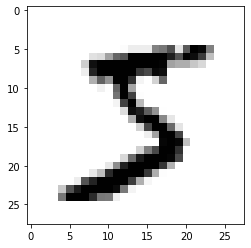

In [4]:
# render one element of the data as an image
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.show

In [5]:
# transform labels into integer data
import numpy as np

y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000]

In [11]:
# Train a binary classifier for the number 5

# create target vectors 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train.values, y_train_5)


SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [9]:
# k-folds cross validation. Split training data into 3 sets (folds). For each fold, train model on the 2 remaining folds 
# and test for accuracy. Will return accuracy > 90 %
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# However, even a classifier that always predicts "not 5" will return about 90% accuracy because only about 10% of the
# numbers are 5's. So accuracy is a bad measure of model performance. 

# Instead use a confusion matrix

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

# Confusion Matrix 
# [non-5 predicted correctly, non-5 predicted incorrectly], 
# [5 predicted incorrectly, 5 predicted correctly]

array([[53892,   687],
       [ 1891,  3530]])